In [47]:
## Imports
from IPython.display import Image
import folium
import pandas as pd
md = {"Model":["Taxi Linear","Taxi GBTree", "Rideshare Linear", "Rideshare GBTree"], "Preicted Fare RMSE ($)": [2.97,1.66, 3.15,2.68]}

# Should I take a Cab?
### Estimating ridesharing and taxi prices in Chicago

Datasets used:
- https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew
- https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p


With the surge in popularity of ridesharing apps such as Uber and Lyft over traditional taxi services, consumers trade convenience for a general lack of transparency regarding prices. Ridesharing services often seem like a better deal than taxi services, but prices fluctuate drastically depending on demand and service choice. Companies such as Bellhop seek to make it easy for users to compare services, and can help users make choices between ridesharing and taxis in real time. I want to find a quantitative answer to the question of whether a given ridesharing price is fair given averages across services and taxi service. The ultimate goal is to build a predictive model of prices for both taxis and ridesharing and allow a user to see how that price compares to averages in their ride category.

Specifically, my proposal centers around two datasets: the recently released 'Transportation Network Providers' (TNP) data and 'Taxi-Trips' data from the city of Chicago government website. Analysis will focus on the most recent data (2018 in for the TNP and 2017 for the taxi trips). A project plan is listed below, with the initial analysis being performed in this notebook.

#### Outline:
1. Initial Results
2. Feature Engineering and Data Cleaning
3. Models and Performance
4. Taxi vs Rideshare comparison
5. Conclusion

### 1: Initial Results


#### 1.1: Notes on the dataset:
- Two datasets, one for taxis and one for ridesharing.
- ~ **40M rows** per dataset, ~**20 features**, 10GB each
- Numerical fields are 'course'
    - Only central lat/long is given
    - Fares often rounded to 2.50\$
    - Distances often rounded to quarter mile... etc.
- Taxi data used from 2016 - 2018
- All ridesharing data used Jul - Nov 2018

#### 1.2: Simple linear model of price trends:

Exploratory analysis of the TNP and taxi dataset shows that the expected strong correlation between trip time/distance and price results in reasonable error of 3.7 and 5 dollars std error for the TNP and taxi dataset respectively. The benefit of using such a simple model is that it can be used to generate pricing rules of thumb between taxis and ridesharing, seen below:

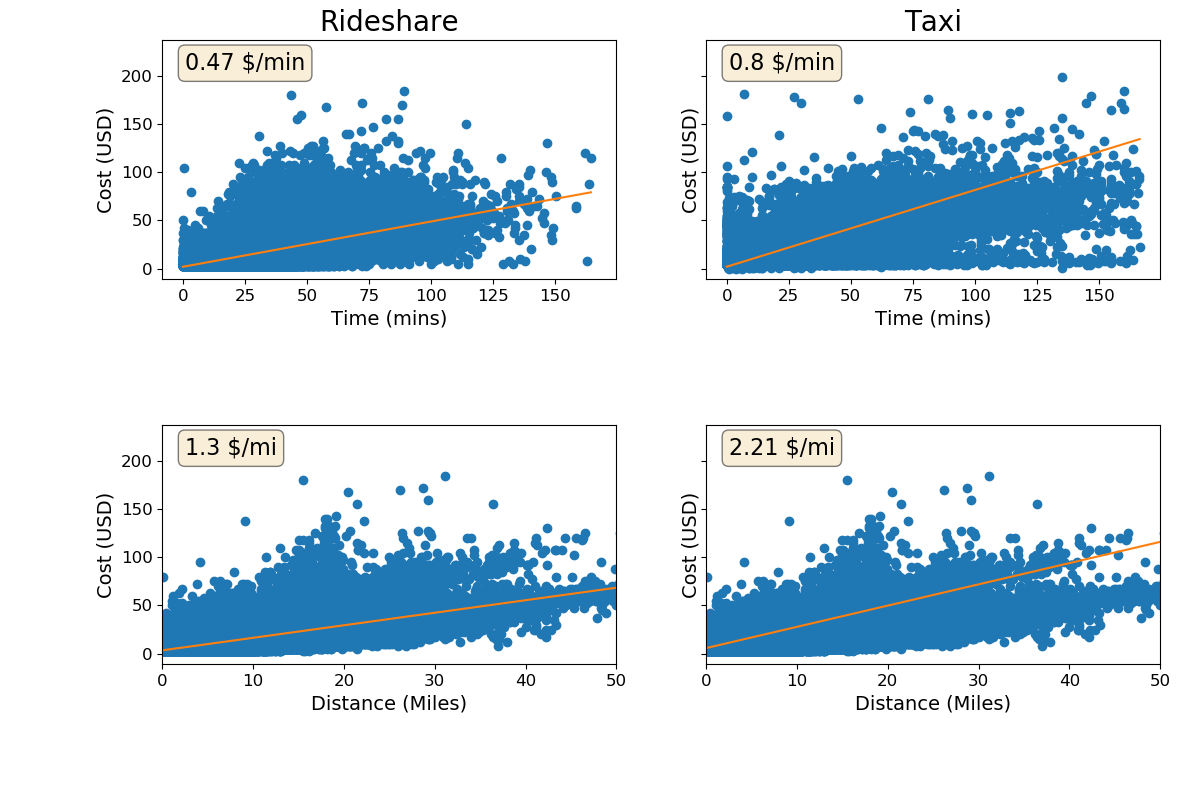

In [36]:
Image("figures/Rideshare_vs_taxi.png")

### 2: Cleaning and Feature Engineering
#### 2.1: Features added
- Velocity
- Distance and Bearing from lat/long
- Day of week/ hour of day
- Airport Trips

#### 2.2: Data removed
- Negative Fare/distance/etc
- Lat/long way outside Chicago
- Velocity > 60 mph

#### 2.3: Correlations
Most of the features are pretty highly correlated, especially the direct distance measurements.

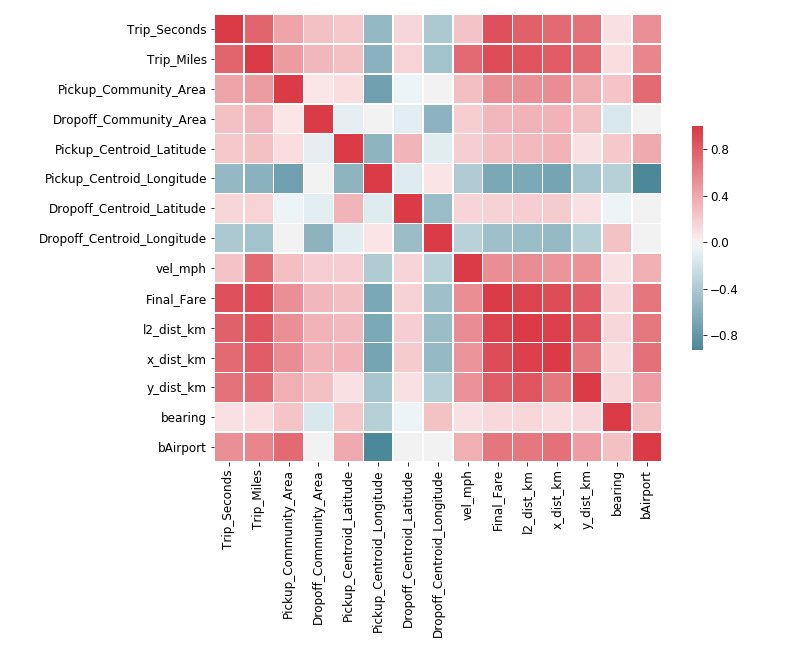

In [65]:
Image("figures/corr.png")

### 3: ML Models

#### 3.1: Linear and gradient-boosed trees
Tried several different ML models and found that for our data size (30M rows x 20 Features) xgboost had low error and trained reasonably fast. Also included is a linear model, which doesn't take huge advantage of the amount of data but is fast and works reasonbly well.

In [64]:
pd.DataFrame(md)

,Model,Preicted Fare RMSE ($)
0,Taxi Linear,2.97
1,Taxi GBTree,1.66
2,Rideshare Linear,3.15
3,Rideshare GBTree,2.68


#### 3.2: Feature Importance
Most of the distance and time related features are the most important. However, they are very correlated with each other so some could most likely get removed without huge performance loss.

In [62]:
imp_df = pd.read_pickle("./importance.pkl")
imp_df[["importance_x","feature_name_x"]].rename(columns={"importance_x": "Importance", "feature_name_x": "Taxi_Feature"})

,Importance,Taxi_Feature
0,661,Trip_Seconds
1,564,l2_dist_km
2,490,y_dist_km
3,471,vel_mph
4,469,x_dist_km
5,437,Trip_Miles
6,393,bearing
7,390,Dropoff_Centroid_Longitude
8,355,Pickup_Centroid_Longitude
9,292,Dropoff_Centroid_Latitude


In [63]:
imp_df[["importance_y","feature_name_y"]].sort_values(by='importance_y',ascending=False).rename(columns={"importance_y": "Importance", "feature_name_y": "Rideshare_Feature"})

,Importance,Rideshare_Feature
7,1495,vel_mph
2,1425,bearing
1,1421,x_dist_km
4,1346,y_dist_km
3,1303,l2_dist_km
9,1294,Dropoff_Centroid_Longitude
11,1221,hour
5,1190,Trip_Miles
8,1071,Dropoff_Centroid_Latitude
0,987,Trip_Seconds


### 4: Taxi vs Rideshare
Our taxi model has significantly lower error, so it makes sense for us to predict taxi prices on given rideshare data.

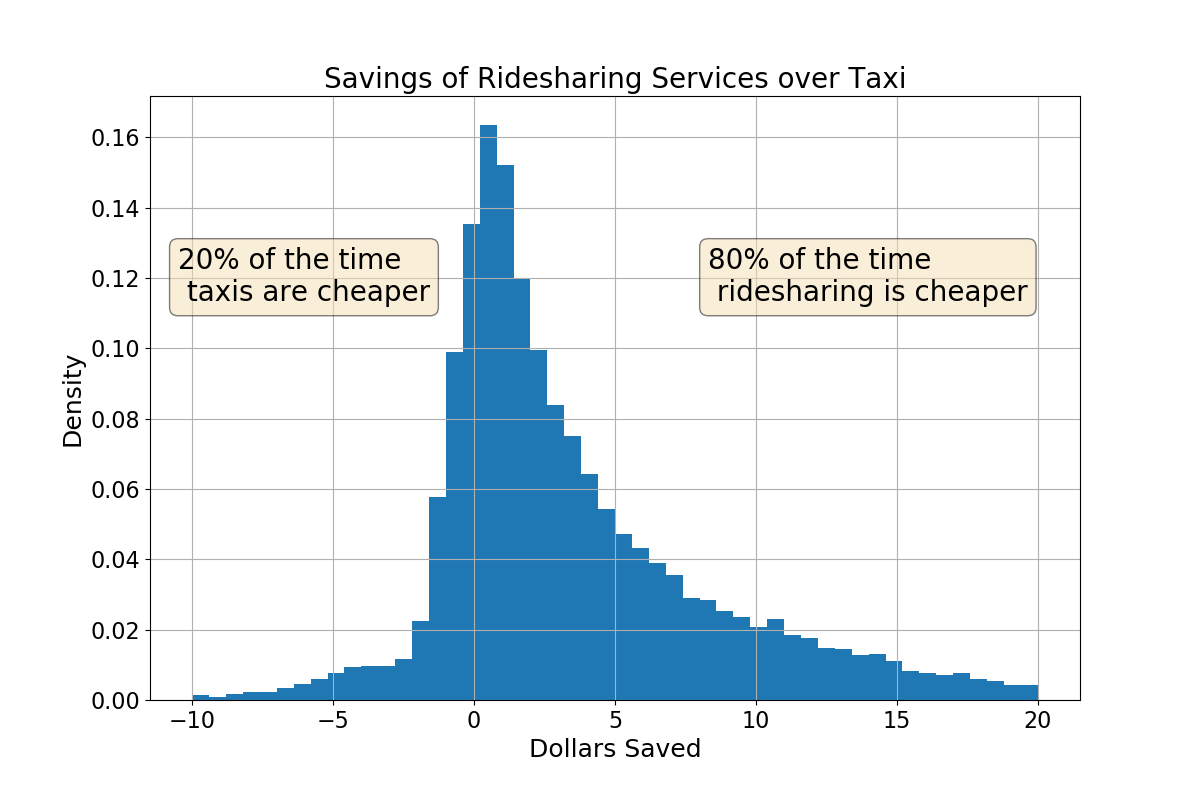

In [49]:
Image("Rideshare_savings.png")

### 5: Conclusion and Future Work
- There is a large enough fraction of trips where taking a taxi is cheaper to be meaningful.
    - This fraction should increase in the future as ridesharing prices are expected to go up after recent IPO's.
- Our models are likely limited by how course the location and fare data is. We don't really need more data, just better data.
- The next steps are:
 1. Create models that do not use the time/distance data (since this would be unknown before a ride).
 2. Create an interactive map for the user to compare model outputs in real time.


